### Imports

In [577]:
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

import numpy as np

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
from basix.ufl import element

import tt
from tt import cross

In [578]:
from scipy.interpolate import BarycentricInterpolator

class eval_collocation:
  def __init__(self, tt_tensor):
    self.cores = tt.vector.to_list(tt_tensor)
    self.r = tt_tensor.r
    self.n = tt_tensor.n[1:]
    
    self.xpoints = []
    for n_i in self.n:
      self.xpoints.append(6 * (0.5 * np.polynomial.legendre.leggauss(n_i)[0] + 0.5) - 3)

    self.polys = []
    for i in range(len(self.n)):
      polys_i = []
      z = np.zeros(self.n[i])
      z[0] = 1
      for k in range(self.n[i]):
        polys_i.append(BarycentricInterpolator(self.xpoints[i], z.copy()))
        # polys_i.append(P.fit(self.xpoints[i], z, self.n[i]-1))
        if k < self.n[i] - 1:
          z[k+1] = 1
          z[k] = 0
      
      self.polys.append(polys_i)

  def __call__(self, y):
    res = np.ones((1,1))
    for i in reversed(range(len(self.n))):
      weight = np.empty((1,self.n[i],1))
      for k in range(self.n[i]):
        weight[0,k,0] = self.polys[i][k](y[i])

      res = np.sum(self.cores[i+1] * weight, axis = 1).reshape(-1, self.r[i+2]) @ res.reshape(self.r[i+2], -1)

    return (self.cores[0].reshape(-1, self.r[1]) @ res.reshape(self.r[1], -1)).flatten()

### Problem definition

In [579]:
c_dim = 10

def dirichlet_boundary(x):
  return np.full(x.shape[1], True)

class coeff:
  def __init__(self, d, nu, k0=1, sigma2=1):
    self.d = d
    self.nu = nu
    self.k0 = k0
    self.sigma2 = sigma2

    self.y = np.zeros(d)

    D = np.arange(self.d, dtype=np.double) - k0 + 1
    D[:k0] = 1
    D = np.power(D, -nu-1)

    self.sqrteta = np.sqrt(sigma2 * D / np.sum(D))

    tau = np.floor(-0.5 + np.sqrt(2 * np.arange(self.d) + 2.25))

    self.pi2rho1 = 1 + np.arange(self.d) - 0.5 * tau * (tau + 1)
    self.pi2rho2 = tau - self.pi2rho1
    self.pi2rho1 *= 2 * np.pi
    self.pi2rho2 *= 2 * np.pi

    print(self.sqrteta)
    
  def __call__(self, x):
    res = np.sum(self.y * self.sqrteta * np.cos(np.outer(x[0], self.pi2rho1)) * np.cos(np.outer(x[1], self.pi2rho2)), axis=1)

    return np.exp(res)
  
diffusion_c = coeff(d=c_dim, nu = 3)
  
# def diffusion_c(x, eps=1e-1):
#   return np.full(x.shape[1], eps)

def convection_b(x, strength=40):
  return np.vstack(
    [strength * x[0] * (2 * x[1] - 1) * (x[0] - 1), 
     -strength  * x[1] * (2 * x[0] - 1) * (x[1] -1)]
    )

def forcing_field(x):
  return 1e1 * np.exp(-(np.sum(np.square(x.T - [.5, .25, 0]), axis = 1))**2 / .005)

[0.69305269 0.69305269 0.17326317 0.07700585 0.04331579 0.02772211
 0.01925146 0.01414393 0.01082895 0.00855621]


### FEM setup

In [580]:
msh = mesh.create_unit_square(comm=MPI.COMM_WORLD,
                              nx=64, ny=64,
                              cell_type=mesh.CellType.triangle)

V = fem.functionspace(msh, ("Lagrange", 1))

# dirichlet = np.zeros(1, dtype=PETSc.ScalarType)  # type: ignore
facets = mesh.locate_entities_boundary(msh, 1, dirichlet_boundary)
bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(V, 1, facets), V)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

Vb = fem.functionspace(msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
b = fem.Function(Vb)
b.interpolate(lambda x: convection_b(x))

c = fem.Function(V)
diffusion_c.y = np.random.uniform(-3,3,10)
c.interpolate(diffusion_c)

f = fem.Function(V)
f.interpolate(forcing_field)

a0 = c * inner(grad(u), grad(v)) * dx
a1 = inner(b, grad(u)) * v * dx
a = a0 + a1
L = f * v * dx

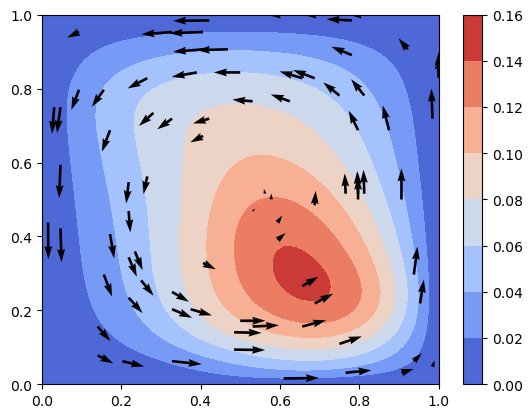

In [581]:
b.interpolate(lambda x: convection_b(x,300))
diffusion_c.y = np.random.uniform(-3,3,10)
c.interpolate(diffusion_c)

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

fig, ax = plt.subplots()
p = ax.tricontourf(x.T[0], x.T[1], uh.x.array, cmap='coolwarm')
# p = ax.tricontourf(x.T[0], x.T[1], forcing_field(x.T), cmap='coolwarm')
fig.colorbar(p, ax=ax)
mask = np.random.rand(N) < 100 / N
dir = convection_b(x[mask].T, 100)
ax.quiver(x[mask].T[0], x[mask].T[1], dir[0], dir[1])

In [582]:
class convection_diffusion_PDE_fun:
  def __init__(self):
    self.msh = mesh.create_unit_square(comm=MPI.COMM_WORLD,
                              nx=64, ny=64,
                              cell_type=mesh.CellType.triangle)

    self.V = fem.functionspace(self.msh, ("Lagrange", 1))

    # dirichlet = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
    facets = mesh.locate_entities_boundary(self.msh, 1, dirichlet_boundary)
    dirichlet_bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(self.V, 1, facets), self.V)
    self.bcs = [dirichlet_bc]

    u = ufl.TrialFunction(self.V)
    v = ufl.TestFunction(self.V)

    self.Vb = fem.functionspace(self.msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
    self.b = fem.Function(self.Vb)

    self.c = fem.Function(self.V)

    self.a0 = fem.form(self.c * inner(grad(u), grad(v)) * dx)
    self.a1 = fem.form(inner(self.b, grad(u)) * v * dx)
    self.a = self.c * inner(grad(u), grad(v)) * dx + inner(self.b, grad(u)) * v * dx
    self.L = fem.form(f * v * dx) # RHS is constant 1

    # precompute constant matrix part
    self.c.interpolate(lambda x : np.zeros(x.shape[1]))
    self.b.interpolate(lambda x: np.zeros((2, x.shape[1])))

    A0 = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
    A0.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A0.getValuesCSR()
    self.A0_const = csr_matrix((av, aj, ai))
    A1 = fem.petsc.assemble_matrix(self.a1, bcs=self.bcs)
    A1.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A1.getValuesCSR()
    self.A1_const = csr_matrix((av, aj, ai))


    b0 = fem.petsc.assemble_vector(self.L)
    fem.petsc.apply_lifting(b0, [fem.form(self.a)], bcs=[self.bcs])
    b0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b0, self.bcs)
    self.b_const = b0.getArray()

  def matrix(self,coeff):
    if len(coeff) != 3:
      raise Exception(f"Wrong number of matrix components ({len(coeff)} != 3).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    c_dofs = coeff[0][0,:,:]
    A0 = []
    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = c_dofs[k,i]
        
      A = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A0.append(csr_matrix((av, aj, ai)) - self.A0_const)

    [num_coeff, nx, I] = np.shape(coeff[1])
    b_dofs = coeff[1][0,:,:]
    A1 = []
    for i in range(I):
      for k in range(self.b.x.array.shape[0]):
        self.b.x.array[k] = b_dofs[k,i]
        
      A = fem.petsc.assemble_matrix(self.a1, bcs=self.bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A1.append(csr_matrix((av, aj, ai)) - self.A1_const)
    
    [num_coeff, nx, I] = np.shape(coeff[2])
    A2 = []
    for i in range(I):
      A2.append(self.A0_const + self.A1_const)
    
    return [A0, A1, A2]
  
  def rhs(self, coeff):
    if len(coeff) != 1:
      raise Exception(f"Wrong number of rhs components ({len(coeff)} != 1).")
       
    [num_coeff, nx, I] = np.shape(coeff[0])
    b0 = []
    for i in range(I):
      b0.append(self.b_const.reshape(-1,1))
    
    return [b0]
  
  def solve(self, coeff):

    [num_coeff, nx, I] = np.shape(coeff[0][0])
    
    U = []

    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = coeff[0][0][0,k,i]
      for k in range(self.b.x.array.shape[0]):
        self.b.x.array[k] = coeff[0][1][0,k,i]

      U.append(self.solve_internal().reshape((-1,1)))
    
    return U

  def solve_internal(self):
    problem = LinearProblem(self.a, self.L, bcs=self.bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    return np.array(uh.x.array)

In [583]:
class convection_diffusion_PDE_fun2:
  def __init__(self, b_func, f_func, mesh_size = 64):
    self.msh = mesh.create_unit_square(comm=MPI.COMM_WORLD,
                              nx=mesh_size, ny=mesh_size,
                              cell_type=mesh.CellType.triangle)

    self.V = fem.functionspace(self.msh, ("Lagrange", 1))

    # dirichlet = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
    facets = mesh.locate_entities_boundary(self.msh, 1, dirichlet_boundary)
    dirichlet_bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(self.V, 1, facets), self.V)
    self.bcs = [dirichlet_bc]

    u = ufl.TrialFunction(self.V)
    v = ufl.TestFunction(self.V)

    self.Vb = fem.functionspace(self.msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
    self.b = fem.Function(self.Vb)
    self.c = fem.Function(self.V)
    self.f = fem.Function(self.V)

    self.a0 = fem.form(self.c * inner(grad(u), grad(v)) * dx)
    self.a1 = fem.form(inner(self.b, grad(u)) * v * dx)
    self.a = self.c * inner(grad(u), grad(v)) * dx + inner(self.b, grad(u)) * v * dx
    self.L = fem.form(self.f * v * dx) # RHS is constant 1

    self.f.interpolate(f_func)
    self.b.interpolate(b_func)

    # precompute constant matrix part
    self.c.interpolate(lambda x : np.zeros(x.shape[1]))

    A0 = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
    A0.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A0.getValuesCSR()
    self.A0_const = csr_matrix((av, aj, ai))

    A1 = fem.petsc.assemble_matrix(self.a1, bcs=self.bcs)
    A1.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A1.getValuesCSR()
    self.A1_const = csr_matrix((av, aj, ai))

    b0 = fem.petsc.assemble_vector(self.L)
    fem.petsc.apply_lifting(b0, [fem.form(self.a)], bcs=[self.bcs])
    b0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b0, self.bcs)
    self.b_const = b0.getArray()

  def quad_weights(self):
    v = ufl.TestFunction(self.V)
    qform = fem.form(v * dx)
    weights = fem.petsc.assemble_vector(qform)
    return weights.getArray()

  def matrix(self,coeff):
    if len(coeff) != 2:
      raise Exception(f"Wrong number of matrix components ({len(coeff)} != 2).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    c_dofs = coeff[0][0,:,:]
    A0 = []
    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = c_dofs[k,i]
        
      A = fem.petsc.assemble_matrix(self.a0, bcs=self.bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A0.append(csr_matrix((av, aj, ai)) - self.A0_const)
    
    [num_coeff, nx, I] = np.shape(coeff[1])
    A1 = []
    for i in range(I):
      A1.append(self.A0_const + self.A1_const)
    
    return [A0, A1]
  
  def rhs(self, coeff):
    if len(coeff) != 1:
      raise Exception(f"Wrong number of rhs components ({len(coeff)} != 1).")
       
    [num_coeff, nx, I] = np.shape(coeff[0])
    b0 = []
    for i in range(I):
      b0.append(self.b_const.reshape(-1,1))
    
    return [b0]
  
  def solve(self, coeff):

    [num_coeff, nx, I] = np.shape(coeff[0][0])
    
    U = []

    for i in range(I):
      for k in range(self.c.x.array.shape[0]):
        self.c.x.array[k] = coeff[0][0][0,k,i]

      U.append(self.solve_internal().reshape((-1,1)))
    
    return U

  def solve_internal(self):
    problem = LinearProblem(self.a, self.L, bcs=self.bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    return np.array(uh.x.array)

### TT decomposition of coefficients

In [584]:
cells, cell_types, coords = plot.vtk_mesh(V)

Ny_c = np.array(c_dim * [10])
Ny_b = np.array(2 * [10])
Nx = coords.shape[0]

ypoints_c = (6 * (0.5 * np.polynomial.legendre.leggauss(Ny_c[0])[0] + 0.5) - 3)
def c_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):    
    diffusion_c.y = ypoints_c[xi[1:]]
    res[i] = diffusion_c(coords[xi[0]].reshape(-1,1))[0]
  
  return res

# random init tensor
TT_c = tt.rand(np.array([Nx] + Ny_c.tolist()),r=10)
# compute TT approx using TT-cross
TT_c = tt.cross.rect_cross.cross(c_func, TT_c, nswp=30, eps = 1e-2, kickrank=5)
TT_c = TT_c.round(1e-12)

print("c TT ranks: ", TT_c.r)

# ypoints_b = (6 * (0.5 * np.polynomial.legendre.leggauss(Ny_b[0])[0] + 0.5) - 3)
# def b_func(x):
#   res = np.empty(x.shape[0])
#   for i, xi in enumerate(x):
#     if xi[0] % 2 == 0:
#       res[i] = ypoints_b[xi[1]]
#     else:
#       res[i] = ypoints_b[xi[2]]
  
#   return res

# # random init tensor
# TT_b = tt.rand(np.array([2*Nx] + Ny_b.tolist() + Ny_c.tolist()),r=10)
# # compute TT approx using TT-cross
# TT_b = tt.cross.rect_cross.cross(b_func, TT_b, nswp=10, eps = 1e-5, kickrank=5)
# TT_b = TT_b.round(1e-12)

# print("b TT ranks: ", TT_b.r)

# helper tensor that is constant 1
cores = [np.ones((1,1,1))]
# for i in range(len(Ny_b)):
#   cores += [np.ones((1,Ny_b[i],1))]
for i in range(len(Ny_c)):
  cores += [np.ones((1,Ny_c[i],1))]

TT_const = tt.vector.from_list(cores)

swp: 0/29 er_rel = 1.5e+04 er_abs = 5.7e+11 erank = 20.1 fun_eval: 167100
swp: 1/29 er_rel = 1.6e-01 er_abs = 6.1e+06 erank = 30.6 fun_eval: 493730
swp: 2/29 er_rel = 3.1e-02 er_abs = 1.2e+06 erank = 42.0 fun_eval: 1032565
swp: 3/29 er_rel = 3.3e-02 er_abs = 1.3e+06 erank = 54.3 fun_eval: 1851545
swp: 4/29 er_rel = 4.0e-03 er_abs = 1.6e+05 erank = 66.7 fun_eval: 3015785
c TT ranks:  [ 1 69 68 68 69 68 70 68 70 76 10  1]


### Run ALS cross

In [585]:
from als_cross import als_cross
# from als_cross_LSTSQ import als_cross_lstsq as als_cross

PDE_fun = convection_diffusion_PDE_fun2(lambda x: convection_b(x, 200), forcing_field)

TT_c_round = TT_c.round(1e-3)
print('coeff TT ranks: ',TT_c_round.r)

test = als_cross(
  [TT_c_round, TT_const],
  [TT_const],
  PDE_fun,
  1e-5,
  random_init=0,
  kickrank=5
  )

test.iterate(3)
print(test.get_stats())

u = test.get_tensor()
u.round(1e-8)

print('Ranks', u.r)

coeff TT ranks:  [ 1 41 37 30 23 18 12  7  5  3  2  1]
= swp=1 core 0, max_dx=1.000e+00, max_rank = 41
= swp=1 core 1>, dx=1.000e+00, rank = [46, 42]
= swp=1 core 2>, dx=1.000e+00, rank = [42, 34]
= swp=1 core 3>, dx=1.000e+00, rank = [34, 26]
= swp=1 core 4>, dx=1.000e+00, rank = [26, 20]
= swp=1 core 5>, dx=1.000e+00, rank = [20, 13]
= swp=1 core 6>, dx=1.000e+00, rank = [13, 8]
= swp=1 core 7>, dx=1.000e+00, rank = [8, 6]
= swp=1 core 8>, dx=1.000e+00, rank = [6, 4]
= swp=1 core 9>, dx=1.000e+00, rank = [4, 3]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 46
= swp=2 core <10, dx=0.000e+00, rank = [4, 1]
= swp=2 core <9, dx=2.955e-04, rank = [5, 4]
= swp=2 core <8, dx=3.447e-03, rank = [7, 5]
= swp=2 core <7, dx=3.439e-03, rank = [9, 7]
= swp=2 core <6, dx=4.923e-02, rank = [14, 9]
= swp=2 core <5, dx=8.755e-02, rank = [22, 14]
= swp=2 core <4, dx=6.156e-01, rank = [29, 22]
= swp=2 core <3, dx=2.070e-01, rank = [38, 29]
= swp=2 core <2, dx=1.621e-02, rank = [47, 38]
= swp=2 core <

In [586]:
qweights = PDE_fun.quad_weights()

def sample(u, PDE_fun, y=None):
  if y is None:
    y = np.random.uniform(-3,3,10)
  
  # TT approx with collocation
  u_coll = eval_collocation(u)(y)
  # get FE solution
  diffusion_c.y = y
  PDE_fun.c.interpolate(diffusion_c)
  u_ref = PDE_fun.solve_internal()

  err2 = np.sum(qweights * np.square(u_coll - u_ref))
  norm2 = np.sum(qweights * np.square(u_ref))

  return u_coll, u_ref, err2 / norm2

L2 err = 7.68e-03


Text(0.5, 1.0, 'Error')

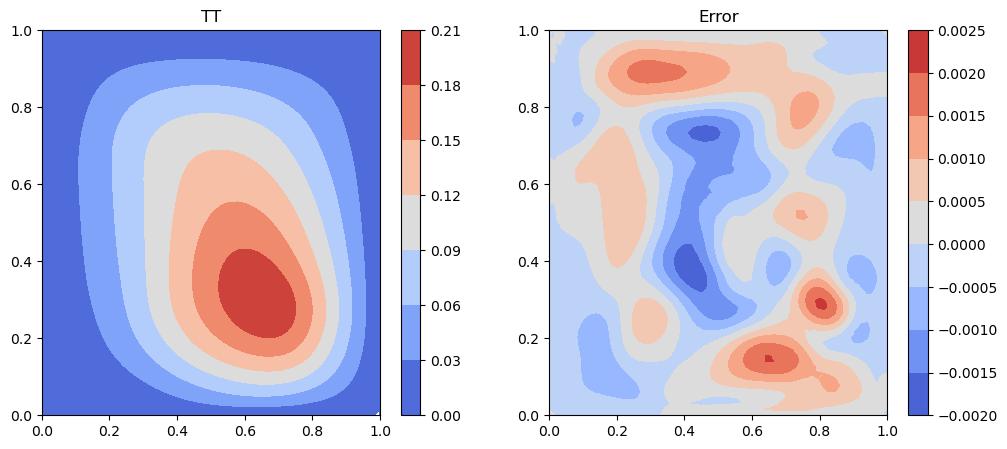

In [587]:
cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

u_coll, u_ref, err2 = sample(u, PDE_fun)

print(f'L2 err = {np.sqrt(err2):.2e}')

# fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12,6))
# axs[0].plot_trisurf(x.T[0], x.T[1], u_coll, cmap='coolwarm')
# axs[0].set_title('TT')
# axs[1].plot_trisurf(x.T[0], x.T[1], u_coll-u_ref, cmap='coolwarm')
# axs[1].set_title('Error')
fig, axs = plt.subplots(1, 2, figsize=(12,5))
p = axs[0].tricontourf(x.T[0], x.T[1], u_coll, cmap='coolwarm')
fig.colorbar(p, ax=axs[0])
axs[0].set_title('TT')
p = axs[1].tricontourf(x.T[0], x.T[1], u_coll-u_ref, cmap='coolwarm')
fig.colorbar(p, ax=axs[1])
axs[1].set_title('Error')

In [590]:
from als_cross import als_cross
from als_cross_LSTSQ import als_cross_lstsq

N_MC = 256
N_sample = 20
strength_arr = [0, 200, 400, 600, 800]

random_init = 40
round_eps = 1e-3
kickrank = 0

errs = []
errs_lstsq = []

for strength in strength_arr:
  PDE_fun = convection_diffusion_PDE_fun2(lambda x: convection_b(x, strength), forcing_field)

  TT_c_round = TT_c.round(round_eps)

  errs.append(0)
  errs_lstsq.append(0)
  for s in range(N_sample):
    worker = als_cross(
      [TT_c_round, TT_const],
      [TT_const],
      PDE_fun,
      1e-5,
      random_init=random_init,
      kickrank=kickrank
      )
    worker.iterate(3)
    u = worker.get_tensor()
    u.round(1e-8)

    worker = als_cross_lstsq(
      [TT_c_round, TT_const],
      [TT_const],
      PDE_fun,
      1e-5,
      random_init=random_init,
      kickrank=kickrank
      )
    worker.iterate(3)
    u_lstsq = worker.get_tensor()
    u_lstsq.round(1e-8)

    err = 0
    err_lstsq = 0
    for N in range(N_MC):
      y = np.random.uniform(-3,3,10)
      err += sample(u, PDE_fun, y)[2]
      err_lstsq += sample(u_lstsq, PDE_fun, y)[2]
    
    errs[-1] += np.sqrt(err / N_MC)
    errs_lstsq[-1] += np.sqrt(err_lstsq / N_MC)

  errs[-1] /= N_sample
  errs_lstsq[-1] /= N_sample

= swp=1 core 0, max_dx=1.000e+00, max_rank = 40
= swp=1 core 1>, dx=1.000e+00, rank = [40, 40]
= swp=1 core 2>, dx=1.000e+00, rank = [40, 40]
= swp=1 core 3>, dx=1.000e+00, rank = [40, 40]
= swp=1 core 4>, dx=1.000e+00, rank = [40, 38]
= swp=1 core 5>, dx=1.000e+00, rank = [38, 31]
= swp=1 core 6>, dx=1.000e+00, rank = [31, 19]
= swp=1 core 7>, dx=1.000e+00, rank = [19, 10]
= swp=1 core 8>, dx=1.000e+00, rank = [10, 6]
= swp=1 core 9>, dx=1.000e+00, rank = [6, 3]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 40
= swp=2 core <10, dx=0.000e+00, rank = [3, 1]
= swp=2 core <9, dx=1.763e-16, rank = [6, 3]
= swp=2 core <8, dx=2.113e-07, rank = [10, 6]
= swp=2 core <7, dx=1.913e-06, rank = [19, 10]
= swp=2 core <6, dx=2.963e-06, rank = [31, 19]
= swp=2 core <5, dx=9.322e-06, rank = [38, 31]
= swp=2 core <4, dx=5.413e-05, rank = [40, 38]
= swp=2 core <3, dx=2.096e-04, rank = [40, 40]
= swp=2 core <2, dx=8.955e-04, rank = [40, 40]
= swp=2 core <1, dx=1.348e-02, rank = [40, 40]
= swp=3 core 0

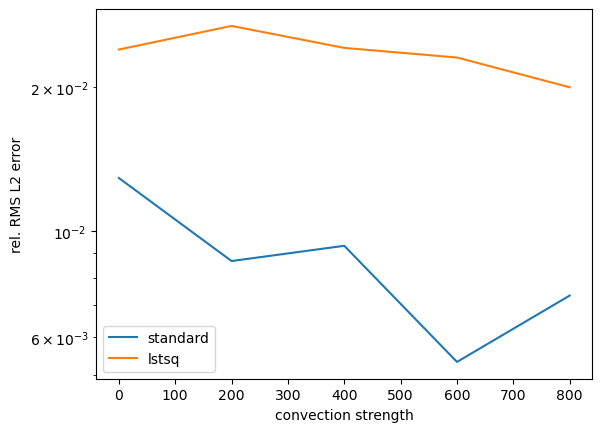

In [591]:
fig, ax = plt.subplots()

ax.plot(strength_arr, errs, label='standard')
ax.plot(strength_arr, errs_lstsq, label='lstsq')

ax.set_xlabel('convection strength')
ax.set_ylabel('rel. RMS L2 error')
ax.set_yscale('log')
ax.legend()